In [ ]:
### we are classifying the tweets between racist and normal tweet. The data was downloaded from analytics vidya

###the link to download dataset is https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/

In [1]:
### we are classifying the Data using 
#-Transformers
#-XgBoost, PassiveAgressiveClasifier(theory when algorithm is applied) and Word2VecEMbeddings
#-Bert Ktrain
!pip install transformers
!pip install ktrain

     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 2.9MB 35.4MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=633e372c7fe258ac9e5ef18a8115e35022fb57ddb77f4f1e2720af9e60104aca
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 25.3MB 149kB/s 
     |████████████████████████████████| 983kB 47.7MB/s 
     |████████████████████████████████| 266kB 44.3MB/s 
     |████████████████████████████████| 1.3MB 46.8MB/s 
     |████████████████████████████████| 1.1MB 44.6MB/s 
     |████████████████████████████████| 471kB 37.7MB/s 
     |████████████████████████████████| 2.9MB 52.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.2-cp36-none-any.whl size=25276305 sha256=9c29810a593d67bd35b0cd59de280463c40db27b94586983a7689

In [4]:
### Importing the libraries
import pandas as pd
from ktrain import text
import ktrain
from nltk.stem import WordNetLemmatizer 
import re
import nltk
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
import itertools
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import unicodedata
import transformers
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [5]:
trainData = pd.read_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/train.csv')

In [6]:
#### In PreProcessing I will remove all the characters starting with @, remove all puntuations words having length less than two characters
###and apply lemmatization on remaing words

lemmatizer = WordNetLemmatizer()
trainData.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
trainData.label.value_counts()
#### data is highly imbalanced


0    29720
1     2242
Name: label, dtype: int64

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
count  = 0
cleanedSentenceList = [] 
tokenData = [] 
for tweet in trainData.tweet:
    
    count = count + 1
    completeSent = '' 
    #if(count > 1000):
        #print(count)
    tokenList = []
    for word in tweet.split(" "):
    
      if word.startswith('@') or len(word.replace(' ','' )) < 1 :
        continue
      else:
        if(word.isdigit() == True):
            continue
        else:
            word1 = re.sub('\W+','',word)
            word1 = re.sub('[^A-Za-z]0-9+', '',word1)
            
            word1 = lemmatizer.lemmatize(word1)
            word1 = word1.replace('ð','')
            word1 = word1.replace('â','')
            word1 = word1.replace(' ','')
            completeSent = completeSent + word1 + ' '
            if(word1 != '' ):
                tokenList.append(word1)
    tokenData.append(tokenList)
    cleanedSentenceList.append(completeSent.rstrip())  
        

In [11]:
trainData['clean_tweet'] = pd.Series(cleanedSentenceList)
trainData['tokenized_tweet'] = pd.Series(tokenData)
trainData.to_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/cleanedTrainData.csv')

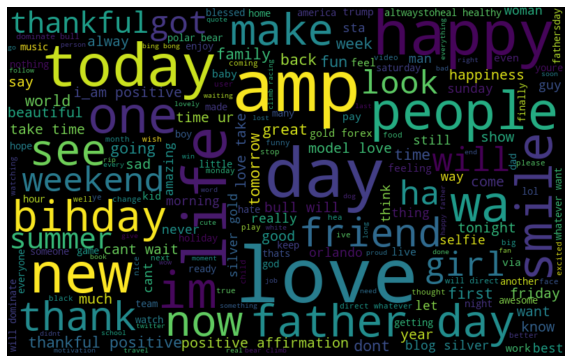

In [ ]:
### Understanding the Most COmmon Words using word cloud 
### ## A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.
all_words = ' '.join([text for text in trainData['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
racistTweet  = trainData.loc[trainData['label'] == 1]
normalTweet  = trainData.loc[trainData['label'] == 0]


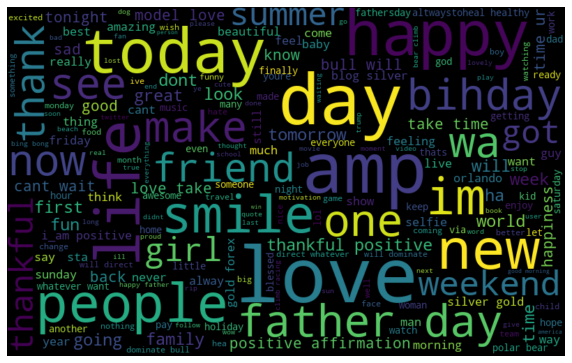

In [ ]:
all_words = ' '.join([text for text in normalTweet['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

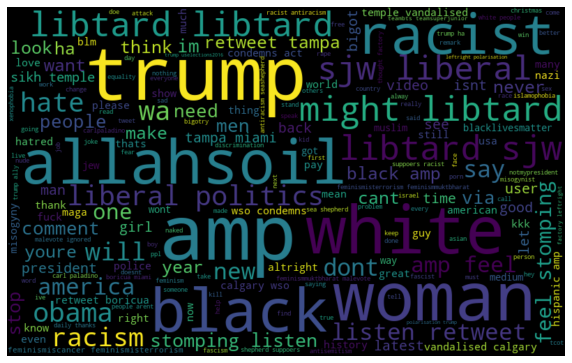

In [ ]:
all_words = ' '.join([text for text in racistTweet['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api
import gensim

In [ ]:


glove_model = None
try:
    glove_model = gensim.models.KeyedVectors.load("./gloveModel.mod")
    print("loading glove")
except:
    glove_model  =api.load('glove-wiki-gigaword-100')  ###100 dimensional word embeddings
    glove_model.save("./glovemodel.mod")
    print("saving glove")

[==================================================] 100.0% 128.1/128.1MB downloaded
saving glove


In [ ]:
#### this method return the embeddings for sentence
def getWordEmbedding(word,model):
    sample = model['computer']
    vector = np.zeros(len(sample), dtype = int)
    try:
        vector = model[word]
    except:
        print("")
    return vector

### adding all the embeddings of words in a sentence
def getPhraseEmbeddings(phrase,model):
    try:
      sampleVector = getWordEmbedding('computer',model)
      vector = np.zeros(len(sampleVector), dtype = int)
      for words in phrase.split():
          vector =vector + np.array(getWordEmbedding(words,model))
        
      return vector.reshape(-1)
    except:
      
      sampleVector = getWordEmbedding('computer',model)
      vector = np.zeros(len(sampleVector), dtype = int)
      return vector
    

In [ ]:
sentenceEmbeddings = [] 
for count,tweet in enumerate(trainData.clean_tweet):
  
  if count%1000 == 0:
    print(count)
  #print(tweet)
  sentenceEmbeddings.append(getPhraseEmbeddings(tweet,glove_model))  #### using glove model


Streaming output truncated to the last 5000 lines.





























































































































































































































































































































































































































































28000




















































































































































































































































































































































































































































































































In [ ]:
len(sentenceEmbeddings)

31962

In [ ]:
y = np.array(trainData['label'])

In [ ]:
X = np.array(sentenceEmbeddings)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state = 0)

In [ ]:
#### Passive Aggressive Classifier

from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(C = 0.1,n_iter_no_change=100,random_state=42)

linear_clf.fit(X_train,y_train)
pred = linear_clf.predict(X_test)
score = metrics.f1_score(y_test,pred)
score

0.1738122827346466

In [ ]:
#### Passive aggressive classifier is useful when we have large amount of data. 
###It is not same as our traditional machine learning model in which batch of data is taken, 
##it take one example at a time update the model and throw the example away
## more details on https://www.geeksforgeeks.org/passive-aggressive-classifiers/

##Passive: If the prediction is correct, keep the model and do not make any changes. i.e., the data in the example is not enough to cause any changes in the model. 
#Aggressive: If the prediction is incorrect, make changes to the model. i.e., some change to the model may correct it.

In [ ]:
#### XGB Boost Classifier

In [ ]:
from xgboost import XGBClassifier
xgboostModel = XGBClassifier(max_depth=50)
xgboostModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pred = xgboostModel.predict(X_test)
score = metrics.f1_score(y_test,pred)
score

0.522432701894317

In [ ]:
#### USing Transformers in Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
### COpied from Internet ### Defining MultiHEad Attention COncept of Transformers
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:

from tensorflow.keras.layers import Embedding  ### Embedding layers is used for textual data
### input layer should obe of same size 
#The sentence is an input to lstm model so to make sure we have sentence of same length we pad the sentence or add zero
    
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot ### to get one hot representation of sentence 

from tensorflow.keras.layers import LSTM,Dense,GRU

In [ ]:
vocab_size = 159089
onehot = [one_hot(words,vocab_size) for words in  trainData['clean_tweet']]
#onehot


In [ ]:
sent_len = 70
embed_docs = pad_sequences(onehot,padding='post',maxlen=sent_len )
embed_docs

array([[115712, 137548,  31656, ...,      0,      0,      0],
       [118390, 150417,  62369, ...,      0,      0,      0],
       [ 76965, 112522, 111749, ...,      0,      0,      0],
       ...,
       [ 20133,  30387, 155092, ...,      0,      0,      0],
       [ 28361,  90812,    784, ...,      0,      0,      0],
       [120246, 113608, 150417, ...,      0,      0,      0]], dtype=int32)

In [ ]:
y=trainData['label']
X=trainData.drop('label',axis=1)


In [ ]:

X_final=np.array(embed_docs)
y_final=np.array(y)

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 32  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(sent_len,))
embedding_layer = TokenAndPositionEmbedding(sent_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(40, activation="tanh")(x)
x = layers.Dropout(0.15)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
token_and_position_embedding (None, 70, 32)            5093088   
_________________________________________________________________
transformer_block (Transform (None, 70, 32)            12704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)               

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_final,y_final,test_size=0.33,random_state = 1)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
   X_train,y_train,validation_data=(X_test,y_test) , batch_size=8, epochs=5
)

Epoch 1/5
2677/2677 [==============================] - 181s 68ms/step - loss: 0.1756 - accuracy: 0.9461 - val_loss: 0.1210 - val_accuracy: 0.9586
Epoch 2/5
1833/2677 [===================>..........] - ETA: 54s - loss: 0.0772 - accuracy: 0.9744

KeyboardInterrupt: ignored

In [ ]:
def returnHighestValue(a,b):
  if a > b:
    return a
  else:
    return b

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[0.996855  , 0.00314494],
       [0.97523195, 0.02476799],
       [0.99617743, 0.00382259],
       ...,
       [0.97641844, 0.02358159],
       [0.96485305, 0.0351469 ],
       [0.01081713, 0.9891829 ]], dtype=float32)

In [ ]:
y_predDf = pd.DataFrame(y_pred)

In [ ]:
y_predDf.to_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/ypred.csv')
#### open in google sheet apply filter using formulka to find cols with highest value =INDEX($B$1:$C$1,MATCH(MAX(B2:C2),B2:C2,0))

In [ ]:
aa= pd.read_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/ypred.csv')
y_pred = aa['Result']

In [ ]:
from sklearn import metrics
score = metrics.f1_score(y_test,y_pred)

In [ ]:
score

0.6639676113360323

In [12]:
#### Bert using Ktrain
#
##Ktrain is library to deploy, build ,debug neural networks and it uses tf.Keras. Ktrain allows us to easily
#-estimate an optimal learning rate of model given data, it uses learning rate finder
#-can load pretrained easy to use state of art models like BERT for text classification
#- there are methods available to load and preprocess text and image data from a variety of poingts
#- it provide simple API for saving and deploying the models,
trainData.isnull().sum()

id                 0
label              0
tweet              0
clean_tweet        0
tokenized_tweet    0
dtype: int64

In [13]:
trainData = trainData.dropna()
trainData['sentiment'] = trainData.label.apply(lambda x : 'Normal' if x == 0 else 'Racist')
trainData.head()

,id,label,tweet,clean_tweet,tokenized_tweet,sentiment
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,"[when, a, father, is, dysfunctional, and, is, ...",Normal
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they d...,"[thanks, for, lyft, credit, i, cant, use, caus...",Normal
2,3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]",Normal
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur,"[model, i, love, u, take, with, u, all, the, t...",Normal
4,5,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]",Normal


In [14]:
validation_data = trainData.sample(5000)
validation_data.head()

,id,label,tweet,clean_tweet,tokenized_tweet,sentiment
29276,29277,0,moving back to vancouver island in a month and...,moving back to vancouver island in a month and...,"[moving, back, to, vancouver, island, in, a, m...",Normal
21552,21553,0,@user i can't believe how big my sons thing i...,i cant believe how big my son thing is already...,"[i, cant, believe, how, big, my, son, thing, i...",Normal
24126,24127,0,i am terrific. #i_am #positive #affirmation,i am terrific i_am positive affirmation,"[i, am, terrific, i_am, positive, affirmation]",Normal
4527,4528,0,i've just posted on my blog about: #secondlife...,ive just posted on my blog about secondlife lo...,"[ive, just, posted, on, my, blog, about, secon...",Normal
21664,21665,0,free creampie sex movies dragon porn,free creampie sex movie dragon porn,"[free, creampie, sex, movie, dragon, porn]",Normal


In [15]:
### preprocessing the data in bert format
(X_train,y_train),(X_test,y_test),pre_process  = text.texts_from_df(train_df =trainData,
                                                                    text_column ='clean_tweet',
                                                                    val_df=validation_data,
                                                                    label_columns ='sentiment',maxlen = 70 ,
                                                                    preprocess_mode = 'bert' )

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [16]:
model  =  text.text_classifier(name='bert',train_data=(X_train,y_train),preproc=pre_process )

### in the name we can give different model name like fasttext for fasttext model, nbsvm,logreg for logistic with embdedding layer
#bigru for biderctional gru with pretrained word vector
#bert and distiber

Is Multi-Label? False
maxlen is 70
done.


In [17]:

####GET LEARNING RATE
import ktrain
learner = ktrain.get_learner(model=model,
                             train_data=(X_train,y_train),
                             batch_size =  4)





In [ ]:
#### this can take time to run
learner.lr_find(max_epochs  = 5 )
learner.lr_plot()

In [ ]:
#### training bert model 
learning_rate  = 1e-5
learner.fit_onecycle(lr= 1e-5,epochs=2)
### run for one or two epochs it will take a lot of time to run



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
7991/7991 [==============================] - 2560s 318ms/step - loss: 0.1980 - accuracy: 0.9247
Epoch 2/2
 565/7991 [=>............................] - ETA: 39:17 - loss: 0.0702 - accuracy: 0.9727

In [ ]:
predictor = ktrain.get_predictor(learner.model,pre_process)

In [1]:
### saving model
predictor.save('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/bertmodelKrtrain')

NameError: ignored

In [ ]:
0

In [ ]:
#### Transfomer and Distilbert

from sklearn.model_selection import train_test_split
from sklearn import metrics
X= list(trainData['clean_tweet'])
y= list(trainData['sentiment'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state = 0)





In [ ]:
model_name = 'distilbert-base-uncased'
transformer = text.Transformer(model_name,maxlen=70,class_names=['Racist','Normal'])

In [ ]:
train_Data= transformer.preprocess_train(X_train,y_train)
test_Data= transformer.preprocess_train(X_test,y_test)


preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 24


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 24


Is Multi-Label? False


In [ ]:
model = transformer.get_classifier()

In [ ]:
learner = ktrain.get_learner(model,train_data=train_Data,val_data=test_Data,batch_size = 16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1338/1338 [==============================] - 173s 129ms/step - loss: 0.3731 - accuracy: 0.9197
Epoch 2/5
1338/1338 [==============================] - 179s 134ms/step - loss: 0.1468 - accuracy: 0.9485
Epoch 3/5
1338/1338 [==============================] - 179s 134ms/step - loss: 0.2492 - accuracy: 0.9320
Epoch 4/5
1338/1338 [==============================] - 176s 132ms/step - loss: 0.4666 - accuracy: 0.9218


done.
Visually inspect loss plot and select learning rate associated with falling loss


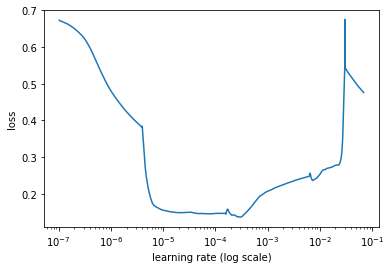

In [ ]:
learner.lr_find(show_plot=True,max_epochs=5)

In [ ]:
learner.fit_onecycle(lr = 1e-5,epochs=3)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/3
1339/1339 [==============================] - 204s 153ms/step - loss: 0.2099 - accuracy: 0.9369 - val_loss: 0.1219 - val_accuracy: 0.9558
Epoch 2/3
1339/1339 [==============================] - 203s 151ms/step - loss: 0.1108 - accuracy: 0.9610 - val_loss: 0.0964 - val_accuracy: 0.9654
Epoch 3/3
1339/1339 [==============================] - 203s 152ms/step - loss: 0.0602 - accuracy: 0.9795 - val_loss: 0.1008 - val_accuracy: 0.9653


In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc= transformer)

In [ ]:
####performin prediction on test data
testData = pd.read_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/test.csv')

In [ ]:
#### Preparing the Test Data
count  = 0
cleanedSentenceList = [] 
tokenData = [] 
for tweet in testData.tweet:
    
    count = count + 1
    completeSent = '' 
    #if(count > 1000):
        #print(count)
    tokenList = []
    for word in tweet.split(" "):
    
      if word.startswith('@') or len(word.replace(' ','' )) < 2 :
        continue
      else:
        if(word.isdigit() == True):
            continue
        else:
            word1 = re.sub('\W+','',word)
            word1 = re.sub('[^A-Za-z]0-9+', '',word1)
            
            word1 = lemmatizer.lemmatize(word1)
            word1 = word1.replace('ð','')
            word1 = word1.replace('â','')
            word1 = word1.replace(' ','')
            completeSent = completeSent + word1 + ' '
            if(word1 != '' ):
                tokenList.append(word1)
    tokenData.append(tokenList)
    cleanedSentenceList.append(completeSent.rstrip())  
        

In [ ]:
testData['clean_tweet'] = pd.Series(cleanedSentenceList)
testData['tokenized_tweet'] = pd.Series(tokenData)

In [ ]:
testData.to_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/testClean.csv')

In [ ]:
### Prdiction using bert ktrain

In [ ]:
testTweetList = list(testData.clean_tweet)

In [ ]:
testResult = []
for count,test_tweet in enumerate(testTweetList):
  aa = predictor.predict(test_tweet)
  testResult.append(aa)
  print(len(testResult))

Streaming output truncated to the last 5000 lines.
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
1

preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 24


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False


NameError: ignored

In [ ]:
### finding index of null row
testData[testData['clean_tweet'].isnull()].index.tolist()


In [ ]:
resultToSubmit = pd.DataFrame(columns=['id','label'])
idList = [i for i in range(31963,49160)]

resultToSubmit['id'] = pd.Series(idList)

resultToSubmit['label'] = pd.Series(testResult)
resultToSubmit['label'] =resultToSubmit['label'] .apply(lambda x: 0 if x == 'Normal' else 1)
resultToSubmit.reset_index()
resultToSubmit.to_csv('/content/drive/MyDrive/NLP_Projects_Manish/Twitter_Sentiment_AnalyticsVidya/resultToSubmit.csv')

In [ ]:
resultToSubmit.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


In [ ]:
testTweetList[1]

'white supremacist want everyone to see the new  birds movie  and heres why'